### Torus Geometry
- **Triangular unit cell**: Primitive vectors |G₁|=|G₂| with 120 degree in between
- **Landau level**: n = 0 (lowest Landau level)
- **Brillouin zone area**: 2π/l² = √0.75 × G²
- **Magnetic length**: l = √(ℏ/eB) sets the length scale

### Bilayer Parameters
- **Nc_hopping = 2**: Number of layers (components)
- **Inter-layer distance**: d/l
- **Tunneling amplitude**: t/W0 (if t=0, should give the same result in example 3)
- **Displacement field**: ΔE/W0, energy difference between layers

### Interaction Details
- **Layer conservation**: Interactions preserve layer index of each particle
- **Layer symmetric**: Interactions unchanged if swap the two layer indices
- **Gate Screening**: D/l
- **Different-layer interaction**: Includes e^{-ql*d/l} attenuation factor
- **Form factor**: See arXiv.2509.07784 Eq.(A28) 

In [1]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED
include("../Landau level triangular.jl")
using .LLT

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum()
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        xlabel = "momentum block number",
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(blocks)
        x = Gk[2] * block_k1[i] + block_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        for e in energies[i]
            scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
        end
    end
    ax_top.xticks = top_ticks
    fig
end

plot_ed_spectrum (generic function with 1 method)

In [2]:
# Define k-mesh for bilayer system (4×3 mesh, Nk=12) in triangular lattice
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions

# Total number of electrons (3 electrons across both layers)
Ne = 6

# Number of layers (components) for bilayer system
Nc_hopping = 2

2

In [3]:
t = 0.0 * LLT.W0               # Inter-layer tunneling strength
ΔE = 0 * LLT.W0                # Energy difference between the two layers

# Set up one-body Hamiltonian matrix for inter-layer tunneling
# H_onebody[c1, c2, cc, k] : hopping from component c2 to c1 at momentum k
# For bilayer system: Nc_hopping=2, Nc_conserve=1
H_onebody_bilayer = zeros(ComplexF64, Nc_hopping, Nc_hopping, 1, Nk)

# Add tunneling terms: t = 0.5 * W0 between different layers
# Tunneling conserves momentum (diagonal in k-space)
for k_idx in 1:Nk
    # Hopping
    H_onebody_bilayer[1, 2, 1, k_idx] = t
    H_onebody_bilayer[2, 1, 1, k_idx] = t
    # onsite energy difference
    H_onebody_bilayer[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer[2, 2, 1, k_idx] = -0.5ΔE
end

# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(
    (1, 0, 1, 0),
    (2, 0, 1, 0)
);

In [7]:
# Interaction parameters

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
sys_int.d_l = 0.1                  # Inter-layer distance d/l
# compute the pseudo-potential components
intra_PP = LLT.pseudo_potential_decomposition.(0:15; same_layer = true,  D_l = sys_int.D_l, d_l = sys_int.d_l)
inter_PP = LLT.pseudo_potential_decomposition.(0:15; same_layer = false, D_l = sys_int.D_l, d_l = sys_int.d_l)
@show intra_PP
@show inter_PP

# Haldane
sys_int.V_intra = [0.0; 0.8; 0.0; 0.0]          # Intralayer Haldane pseudo-potential in unit of W0
sys_int.V_inter = [1.5; 0.0; 0.0; 0.0]          # Interlayer Haldane pseudo-potential in unit of W0

# or use Coulomb interaction with a cutoff in m
# sys_int.V_intra = copy(intra_PP)
# sys_int.V_inter = copy(inter_PP)

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 1                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para_bilayer = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = Nc_hopping,
    Nc_conserve = 1,
    H_onebody = H_onebody_bilayer,
    V_int = sys_int,
    FF_inf_angle = LLT.Landau_ff_inf(sys_int),
);

intra_PP = [1.6347066215405632, 0.7493532823751158, 0.5286565941067406, 0.41872505368204593, 0.3503224973226579, 0.3026782860863603, 0.2671381550406759, 0.2393751098165452, 0.21695533203249928, 0.19839158716928695, 0.18271725829183577, 0.16927336306332738, 0.15759318809374134, 0.1473357319489056, 0.13824529565043234, 0.13012589008205516]
inter_PP = [1.538982326541291, 0.7473021108429173, 0.5281101963919731, 0.4184538927733024, 0.3501548452430184, 0.3025623702653087, 0.26705238102427886, 0.2393086769107607, 0.21690216474877644, 0.19834797338980364, 0.1826807859849803, 0.1692423884973554, 0.15756654773338755, 0.14731257622096056, 0.13822498800698133, 0.13010794307028975]


In [8]:
# Create momentum blocks for bilayer system
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para_bilayer, ED_mbslist(para_bilayer, (Ne,)));
display(length.(blocks))

# Generate scattering lists for efficient Hamiltonian construction
scat_list1 = ED_sortedScatteringList_onebody(para_bilayer);
scat_list2 = ED_sortedScatteringList_twobody(para_bilayer);

12-element Vector{Int64}:
 11202
 11196
 11196
 11240
 11232
 11232
 11202
 11196
 11196
 11240
 11232
 11232

In [9]:
Neigen = 10
energies = Vector{Vector{Float64}}(undef, length(blocks))
vectors = Vector{Vector{Vector{ComplexF64}}}(undef, length(blocks))
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    energies[i], vectors[i] = EDsolve(blocks[i], scat_list2, scat_list1; 
        N = Neigen, showtime=true,
    )
end

Processing block #1 with size 11202, momentum 0, 0
  2.845447 seconds (37.36 M allocations: 802.609 MiB, 15.46% gc time, 92.48% compilation time)
  7.693779 seconds (13.46 M allocations: 881.819 MiB, 4.55% gc time, 99.44% compilation time)
Processing block #2 with size 11196, momentum 0, 1
  1.546094 seconds (36.28 M allocations: 747.682 MiB, 16.80% gc time)
  0.734160 seconds (5.97 k allocations: 122.645 MiB, 2.25% gc time)
Processing block #3 with size 11196, momentum 0, 2
  1.747362 seconds (36.28 M allocations: 747.678 MiB, 24.61% gc time)
  0.630126 seconds (5.93 k allocations: 122.299 MiB, 1.92% gc time)
Processing block #4 with size 11240, momentum 1, 0
  1.527027 seconds (36.44 M allocations: 751.284 MiB, 15.94% gc time)
  1.199942 seconds (10.73 k allocations: 226.898 MiB, 2.09% gc time)
Processing block #5 with size 11232, momentum 1, 1
  1.749516 seconds (36.41 M allocations: 750.580 MiB, 19.17% gc time)
  0.792899 seconds (6.63 k allocations: 138.193 MiB, 7.82% gc time)
Pro

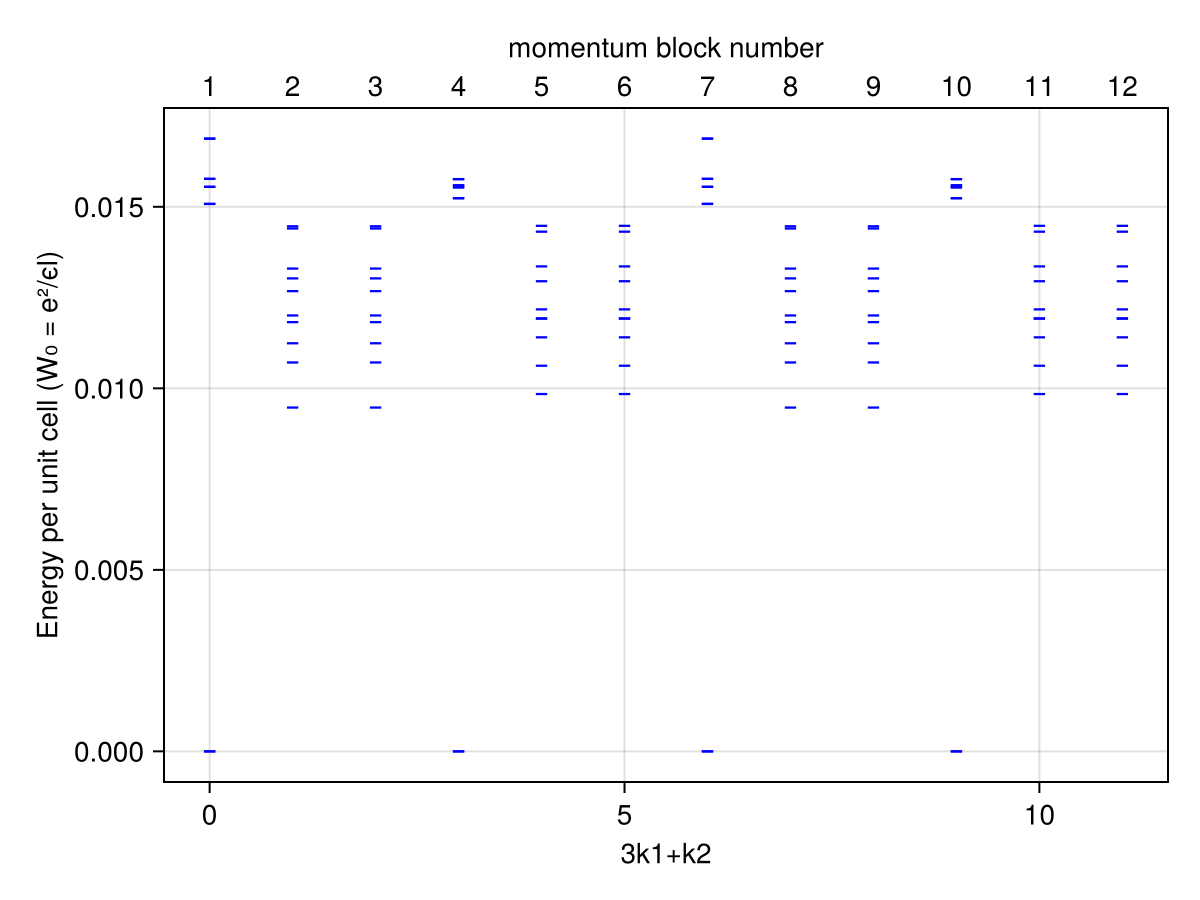

In [10]:
plot_ed_spectrum()

In [12]:
# check energies explicitly to see degeneracy.

bn = 1 # the block number to inspect
println("total momentum: ", block_k1[bn], "  ", block_k2[bn])
energies[bn]/Nk/LLT.W0

total momentum: 0  0


10-element Vector{Float64}:
 -1.2740182169324636e-14
 -1.2358939733489074e-14
  0.01507901688406047
  0.015079016884060603
  0.015549350899221501
  0.015549350899221576
  0.01576889864943778
  0.015768898649437993
  0.0168771101143454
  0.016877110114345662

Compute and plot one-body reduced density matrix

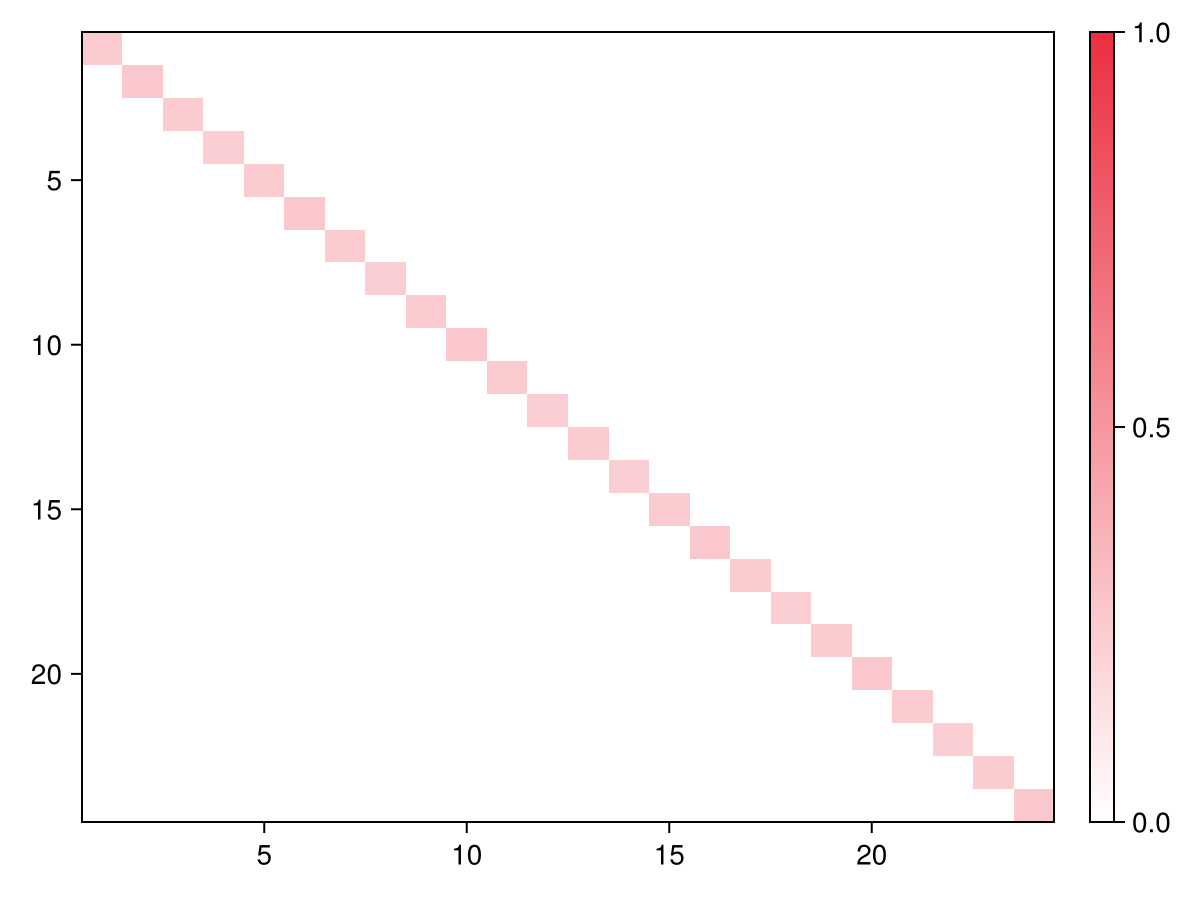

In [13]:
# plot the reduced density matrix of the ground eigenstate in the first block
rdm = ED_onebody_rdm(blocks[bn], vectors[bn][1])

fig = Figure();
ax = Axis(fig[1, 1]; yreversed = true)
hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
    colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
)
Colorbar(fig[1, 2], hm)
fig

Compute the many-body connection and the Wilson loop for many-body Chern number.

In [ ]:
# path for the Wilson loop integral on base manifold
# Landau level has uniform Berry curvature, so we compute Berry curvature of a small plaquate and then multiply plaquate number
N_shift = 8  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
push!(path, (1/N_shift, 0.0))
push!(path, (1/N_shift, 1/N_shift))
push!(path, (0.0, 1/N_shift))
push!(path, (0.0, 0.0))
path

5-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.125, 0.0)
 (0.125, 0.125)
 (0.0, 0.125)
 (0.0, 0.0)

In [21]:
bn = 1                     # block number
nstates = 2                # number of degenerating states

psi_before = reduce(hcat, vectors[bn][1:nstates])
ED_connection_gaugefixing!(psi_before,  collect(1000:1000+nstates-1))  # fix global phase
psi_after = similar(psi_before)

WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    scat_list = ED_sortedScatteringList_twobody(para_bilayer; kshift = path[i+1]);
    vecs = EDsolve(blocks[bn], scat_list; N = 6,
        showtime = false,
    )[2][1:nstates]
    psi_after .= reduce(hcat, vecs)
    ED_connection_gaugefixing!(psi_after,  collect(1000:1000+nstates-1))  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step(blocks[bn], 
        psi_after, psi_before, path[i+1], path[i], para_bilayer;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2


path point #1 	 (0.125, 0.0)
Inner product: amp = 0.9999999999999964, phase = -0.19634954084934628
path point #2 	 (0.125, 0.125)
Inner product: amp = 0.9999999999999947, phase = 0.5726861608106366
path point #3 	 (0.0, 0.125)
Inner product: amp = 0.9999999999999976, phase = 0.24543692606169873
path point #4 	 (0.0, 0.0)
Inner product: amp = 1.000000000000001, phase = -0.5235987755983001


1.0000000000000804